# "This Cat Doesn't Exist" v1
## Variational Autoencoders To Generate Cats

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import IPython.display as ipd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import time
import glob
from PIL import Image

## Dataset Definitions / Example

torch.Size([3, 64, 64])


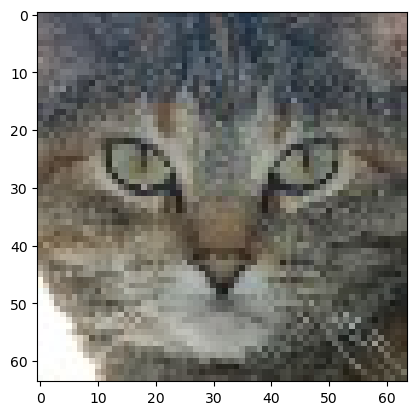

In [2]:
class CatData(Dataset):
    def __init__(self, foldername, imgres=64, train=True):
        self.images = glob.glob("{}/*".format(foldername))
        self.preprocess = transforms.Compose([
            transforms.Resize(imgres),
            transforms.ToTensor()
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        img = self.preprocess(img)
        if torch.max(img) > 1:
            img /= 255
        return img
         
traindata = CatData("cats", train=True, imgres=64)
X = traindata[0]
print(X.shape)
X = X.numpy()
X = np.moveaxis(X, 0, 2)
plt.imshow(X)

Color: 3: (R, G, B)
Breed: 4
Eye Color 3 (R, G, B)
Lighting 3 (R, G, B)
Whisker Length 1

There are many "semantic dimension" that are independent 

## Model Definition

In [3]:
class ConvAutoencoder(nn.Module):
    def __init__(self, depth=4, dim_latent=64, dim_img=64, in_channels=3):
        """
        depth: int
            How many convolutional layers there are in the encoder/decoder
        dim_latent: int
            Dimension of the latent space
        dim_digit: int
            Width/height of input image
        in_channels: int
            Number of channels of input image
        """
        super().__init__()
        self.dim_latent = dim_latent
        
        ## Step 1: Create convolutional encoder
        in_orig = in_channels
        layers = []
        out_channels = 64
        for i in range(depth):
            layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding=1))
            layers.append(nn.LeakyReLU())
            in_channels = out_channels
            out_channels *= 2
        # Create a dummy input to get the shape right
        X = torch.zeros(1, in_orig, dim_img, dim_img)
        XOut = nn.Sequential(*layers)(X)
        shape = XOut.shape[1::]
        layers += [nn.Flatten()]
        self.encoder = nn.Sequential(*layers)
        
        # Create a linear layer for both mu and sigma
        self.mu_enc = nn.Sequential(nn.Linear(np.prod(shape), dim_latent), nn.Tanh())
        self.sigma_enc = nn.Sequential(nn.Linear(np.prod(shape), dim_latent), nn.ReLU())
        
        ## Step 2: Setup convolutional decoder
        layers = [nn.Linear(dim_latent, np.prod(shape)), nn.LeakyReLU(), nn.Unflatten(1, shape)]
        in_channels = out_channels//2
        for i in range(depth):
            out_channels = 3
            if i < depth-1:
                out_channels = in_channels // 2
            # Use upsampling with bilinear interpolation instead of ConvTranspose
            # to avoid checkerboard artifacts
            # See this link for more info: https://distill.pub/2016/deconv-checkerboard/
            layers.append(nn.Upsample(scale_factor=2, mode='bilinear'))
            layers.append(nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1))
            layers.append(nn.LeakyReLU())
            in_channels = out_channels

        self.decoder = nn.Sequential(*layers)
    
    def forward(self, X):
        flat_dim = self.encoder(X)
        # Estimate mu and sigma
        mu = 5*self.mu_enc(flat_dim)
        sigma = self.sigma_enc(flat_dim)
        # Use reparam trick to sample a z in the latent space
        z = mu + sigma*torch.randn(sigma.shape).to(sigma)
        XOut = self.decoder(z) # Decoding
        
        # Fit the data
        loss_fit = torch.sum((X-XOut)**2)
        # Fit the prior (mu=0, sigma=1)
        kl_div = 0.5*torch.sum(sigma**2 + mu**2 - 1 - torch.log(1e-8 + sigma**2), dim=1)
        kl_div = torch.mean(kl_div)
        
        return z, XOut, (loss_fit, kl_div)
    
    def sample(self, n_examples, device):
        """
        Sample from the latent space and generate the images from the decoder
        """
        # Generate samples from Gaussian with mean 0, sigma 1
        z = torch.randn(n_examples, self.dim_latent).to(device)
        return self.decoder(z)

def plot_samples(XGen):
    k = int(np.sqrt(XGen.shape[0]))
    for i in range(XGen.shape[0]):
        plt.subplot(k, k, i+1)
        Xi = XGen[i, :, :, :].detach().cpu().numpy()
        Xi = np.moveaxis(Xi, 0, 2)
        Xi[Xi < 0] = 0
        Xi[Xi > 1] = 1
        plt.imshow(Xi)
        plt.axis("off")

## Training

Epoch 29 batch 900: loss fit 163.553, loss prior 1.919


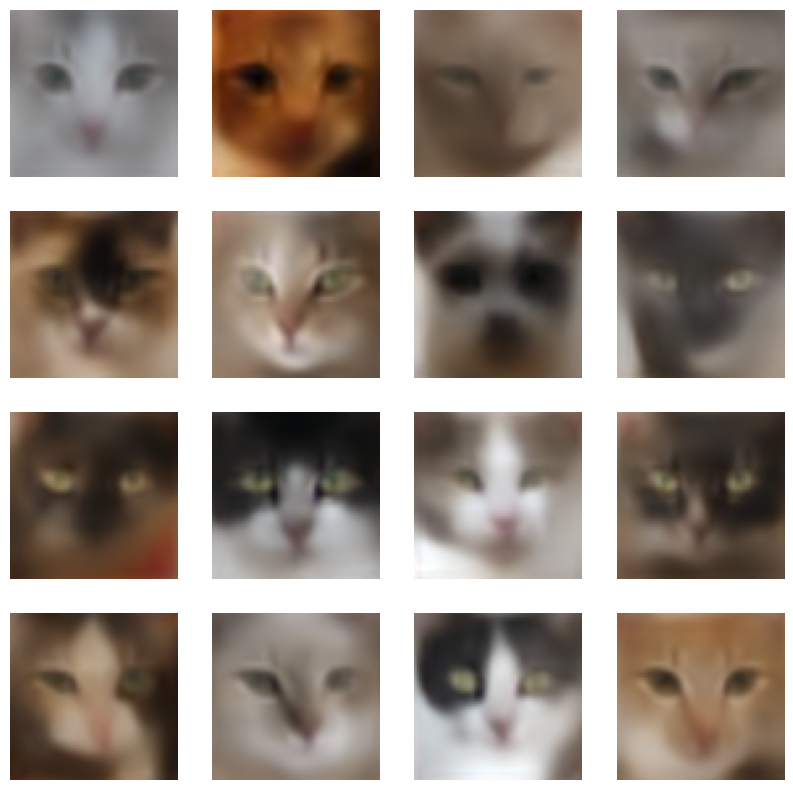

In [4]:
device = 'cuda'
model = ConvAutoencoder()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

n_epochs = 30
batch_size = 16
train_losses_fit = []
train_losses_prior = []

plt.figure(figsize=(10, 10))
lam = 30

for epoch in range(n_epochs):
    model.train()
    loader = DataLoader(traindata, batch_size=batch_size, shuffle=True)
    train_loss_fit = 0
    train_loss_prior = 0
    for i, X in enumerate(loader): # Go through each mini batch
        X = X.to(device)
        # Reset the optimizer's gradients
        optimizer.zero_grad()
        # Run the sequential model on all inputs
        _, _, (loss_fit, loss_prior) = model(X)
        # Compute the gradients of the loss function with respect
        # to all of the parameters of the model
        loss = loss_fit + lam*loss_prior
        loss.backward()
        # Update the parameters based on the gradient and
        # the optimization scheme
        optimizer.step()
        train_loss_fit += loss_fit.item()
        train_loss_prior += loss_prior.item()
        
        if i%100 == 0:
            ipd.clear_output()
            print("Epoch {} batch {}: loss fit {:.3f}, loss prior {:.3f}".format(
                epoch, i, train_loss_fit/((i+1)*batch_size),
                        train_loss_prior/((i+1)*batch_size)))
    
    train_losses_fit.append(train_loss_fit/len(traindata))
    train_losses_prior.append(train_loss_prior/len(traindata))
    
    plt.clf()
    XSamples = model.sample(16, device)
    plot_samples(XSamples)
    plt.savefig("Epoch{}.png".format(epoch))

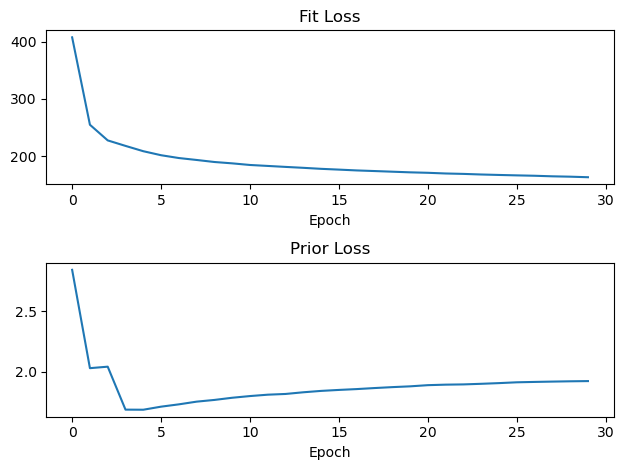

In [5]:
plt.subplot(211)
plt.plot(train_losses_fit)
plt.xlabel("Epoch")
plt.title("Fit Loss")
plt.subplot(212)
plt.plot(train_losses_prior)
plt.xlabel("Epoch")
plt.title("Prior Loss")
plt.tight_layout()